# Lorenz Curve and Gini Coefficient

In [1]:
#import of functions defined in the assingment_I.py file
from assingment_I import *

%load_ext autoreload
%autoreload 2

## 1.a

In [2]:
# import of 21in14ar.xls from line 7-27 and only 3 first columns
data_raw21 = pd.read_excel('21in14ar.xlsx', header=7, usecols=[0,1,2])

# renaming of columns
data_raw21.columns = ['Size of adjusted gross income', 'Number of returns', 'Adjusted gross income less deficit']

# dropping rows after 20th row no matter the value
data_raw21 = data_raw21.drop(data_raw21.index[20:])

# adjusting data type
data_raw21['Number of returns'] = data_raw21['Number of returns'].astype(int)
data_raw21['Adjusted gross income less deficit'] = data_raw21['Adjusted gross income less deficit'].astype(int)

# printing of data
display(data_raw21)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit
0,"All returns, total",160824340,14795614070
1,No adjusted gross income,4098522,-171836364
2,"$1 under $5,000",8487025,19987243
3,"$5,000 under $10,000",8944908,67651359
4,"$10,000 under $15,000",10056377,125912056
5,"$15,000 under $20,000",9786580,170836129
6,"$20,000 under $25,000",8863570,199508960
7,"$25,000 under $30,000",8787576,241347179
8,"$30,000 under $40,000",16123068,561386434
9,"$40,000 under $50,000",12782334,573155378


In [3]:
data21 = clean_data(data_raw21, print_head=True)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit,Total number of returns,Total adjusted gross income less deficit,Percentage of total returns,Percentage of total AGI,Cumsum percentage of total returns,Cumsum percentage of total AGI
0,0,0,0,156725818,14967450434,0.000000,0.000000,0.000000,0.000000
1,"$1 under $5,000",8487025,19987243,156725818,14967450434,0.054152,0.001335,0.054152,0.001335
2,"$5,000 under $10,000",8944908,67651359,156725818,14967450434,0.057074,0.004520,0.111226,0.005855
3,"$10,000 under $15,000",10056377,125912056,156725818,14967450434,0.064165,0.008412,0.175391,0.014268
4,"$15,000 under $20,000",9786580,170836129,156725818,14967450434,0.062444,0.011414,0.237835,0.025682


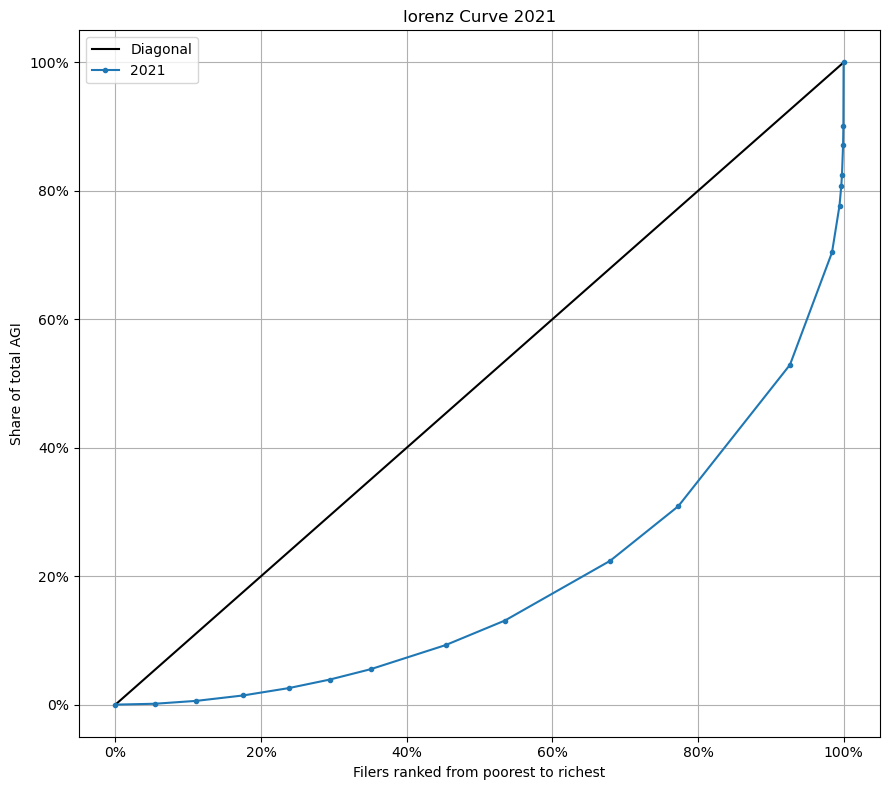

In [4]:
plot_lorenz_curve(data21,save='lorenz_curve1a.png',title='lorenz Curve 2021',data_label='2021')

In [5]:
gini21 = gini_coefficient(data21, print_gini=True)

Gini coefficient: 0.627922555865702


## 1.b

Interpolated value for top 10.00% share of total AGI: 0.5086656077832005
Interpolated value for top 1.00% share of total AGI: 0.2540233716155428


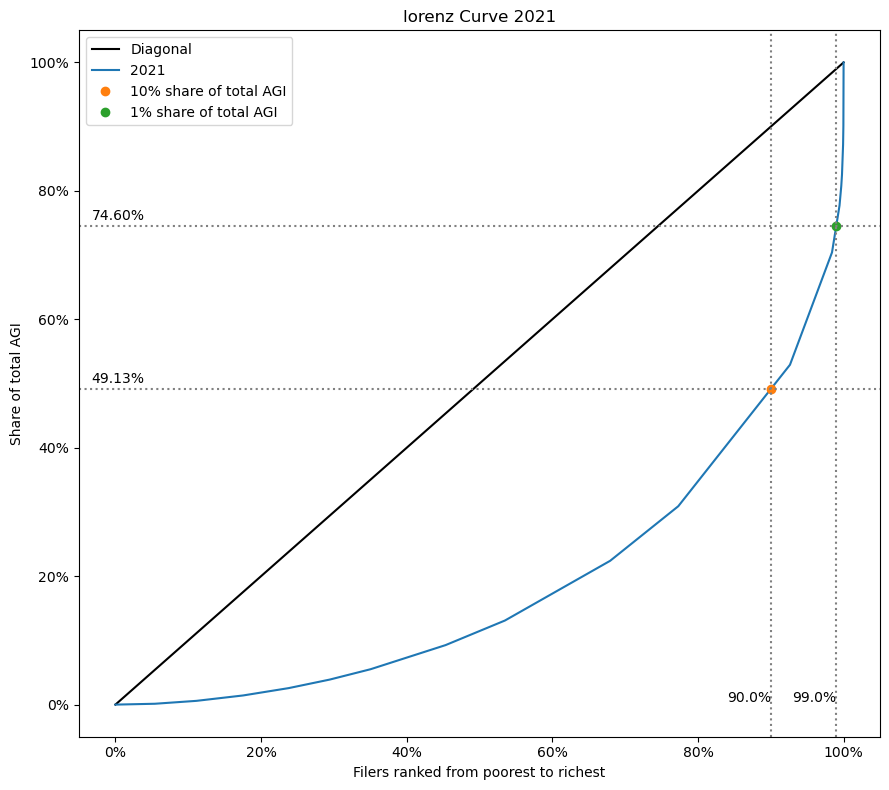

In [6]:
plot_lorenz_curve(data21, shares=[0.90, 0.99],save='lorenz_curve1b.png', title='lorenz Curve 2021', data_label='2021')

## 1.c

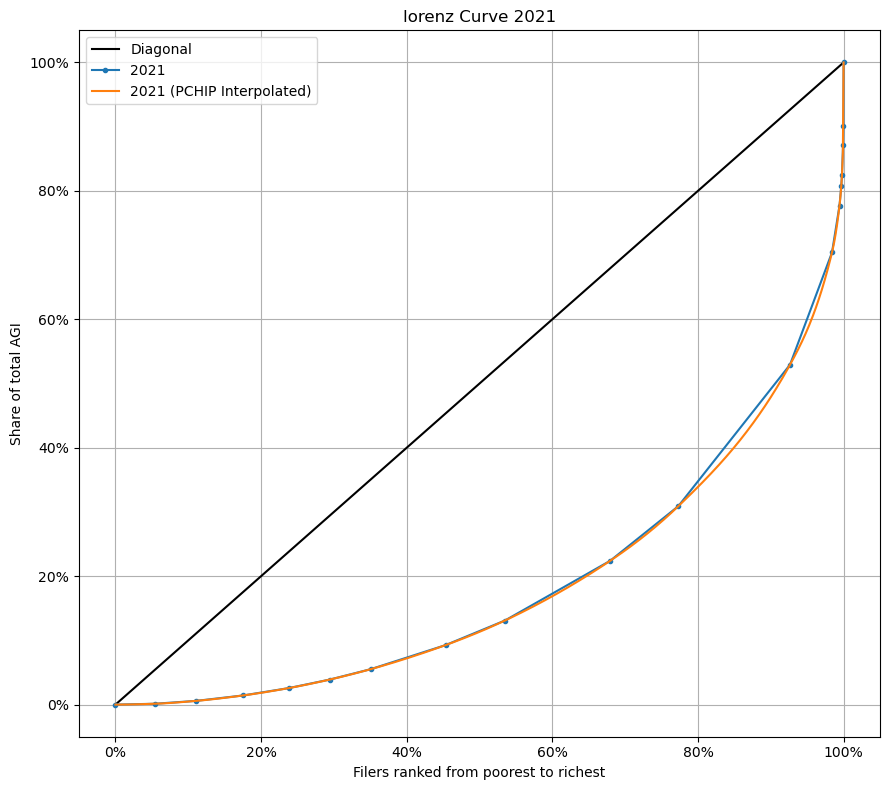

In [7]:
plot_lorenz_curve(data21,save='lorenz_curve1c.png',title='lorenz Curve 2021',data_label='2021',pchip=True,)

## 1.d

In [8]:
# import of 21in14ar.xls from line 7-27 and only 3 first columns
data_raw93 = pd.read_excel('93in14si.xlsx', header=6, usecols=[0,1,2])

# renaming of columns
data_raw93.columns = ['Size of adjusted gross income', 'Number of returns', 'Adjusted gross income less deficit']

# dropping rows after 20th row no matter the value
data_raw93 = data_raw93.drop(data_raw93.index[16:])

# adjusting data type
data_raw93['Number of returns'] = data_raw93['Number of returns'].astype(int)
data_raw93['Adjusted gross income less deficit'] = data_raw93['Adjusted gross income less deficit'].astype(int)

# printing of data
display(data_raw93)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit
0,"All returns, total",114601819,3723339880
1,No adjusted gross income,920431,-52237725
2,"$1 under $5,000",14850154,37291560
3,"$5,000 under $10,000",14727738,110431929
4,"$10,000 under $15,000",13469144,167569389
5,"$15,000 under $20,000",11370849,198121307
6,"$20,000 under $25,000",9474601,212328659
7,"$25,000 under $30,000",7783773,212848223
8,"$30,000 under $40,000",12358341,429243404
9,"$40,000 under $50,000",9072138,405366468


In [9]:
data93 = clean_data(data_raw93, print_head=True)

,Size of adjusted gross income,Number of returns,Adjusted gross income less deficit,Total number of returns,Total adjusted gross income less deficit,Percentage of total returns,Percentage of total AGI,Cumsum percentage of total returns,Cumsum percentage of total AGI
0,0,0,0,113681388,3775577605,0.000000,0.000000,0.000000,0.000000
1,"$1 under $5,000",14850154,37291560,113681388,3775577605,0.130630,0.009877,0.130630,0.009877
2,"$5,000 under $10,000",14727738,110431929,113681388,3775577605,0.129553,0.029249,0.260182,0.039126
3,"$10,000 under $15,000",13469144,167569389,113681388,3775577605,0.118482,0.044382,0.378664,0.083509
4,"$15,000 under $20,000",11370849,198121307,113681388,3775577605,0.100024,0.052474,0.478688,0.135983


Interpolated value for top 10.00% share of total AGI: 0.38273362948270595
Interpolated value for top 1.00% share of total AGI: 0.13556562812293982


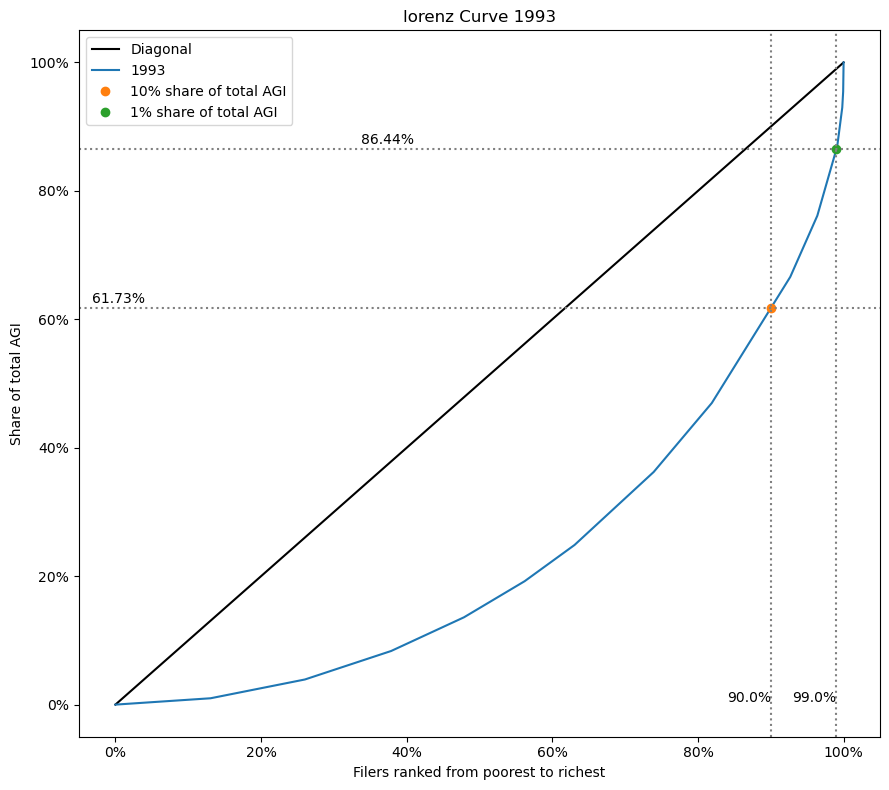

In [10]:
plot_lorenz_curve(data93, data_label='1993', shares=[0.90, 0.99], title='lorenz Curve 1993', save='lorenz_curve1d.png')

In [11]:
gini93 = gini_coefficient(data93, print_gini=True)

Gini coefficient: 0.5296265854024349


## 1.e

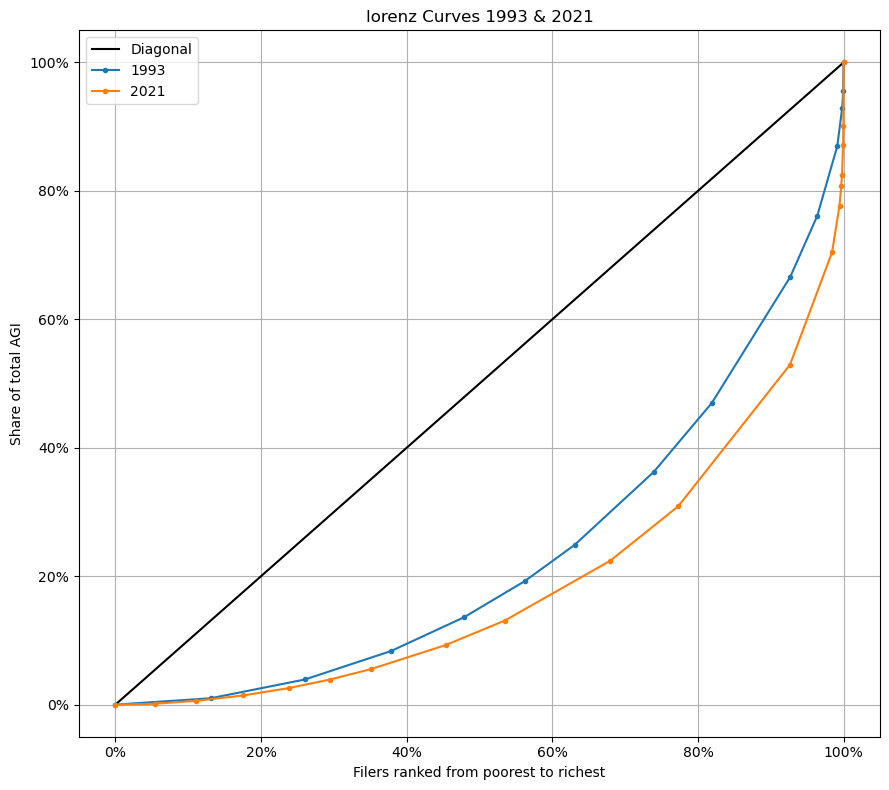

In [12]:
plot_lorenz_curve(data93, data_label='1993', compare=data21, compare_label='2021', title='lorenz Curves 1993 & 2021', save='lorenz_curve1e.png')